In [99]:
import astropy.io.fits as pf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from astropy import constants as const
from astropy import units as u
#import tycholib_jupyter as tj
import matplotlib.ticker as ticker
import imp
import sys, os, glob
import tycholib_jupyter_finalpaper_v2 as tj
imp.reload(tj)
import math
import json
from astropy.io import ascii
import matplotlib.gridspec as gridspec # For spacing subplots
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel
from astropy.coordinates import SkyCoord
import math
import time
from astropy.visualization import (LogStretch, ImageNormalize, SqrtStretch)
import pandas as pd
from astroquery.splatalogue import Splatalogue as splat
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [100]:
########### plotting setup ####################################################


from matplotlib.colors import LinearSegmentedColormap
def custom_div_cmap(numcolors=11,name='custom_div_cmap',colorarray=['blue','white','red']):
   cmap = LinearSegmentedColormap.from_list(name=name,
                                            colors=colorarray,
                                            N=numcolors)
   return cmap

blueorange = ['#0e4c72','#2e74a0','#3faeba','#88dfe8','#C3EDA5','#fffc63','#cdd313','#ce9300','#c65c00','#7a2c00']
whiteorange = ['#ffffff','#3B5998','#00a0d1','#bbffee','#c3e88d','#f7c56e','#ff7700','#cb1d1d']
blackorange = ['#000000','#3B5998','#00a0d1','#bbffee','#c3e88d','#f7c56e','#ff7700','#cb1d1d']

cmap_whiteorange = custom_div_cmap(256,'custom_div_cmap',whiteorange)
cmap_blackorange = custom_div_cmap(256,'custom_div_cmap',blackorange)
cmap_blueorange = custom_div_cmap(256,'custom_div_cmap',blueorange)


cmap_blueorange.set_under('#0e4c72')
cmap_blueorange.set_bad('#0e4c72')
cmap_blueorange.set_over('#7a2c00')


In [101]:
FitsDictionary = {}
prefixes = ['../../ALMA/TMC1/12m/Band6_1350/product/','../../ALMA/TMC1/12m/Band6_1413/',\
            ]
names = [
         'TMC1_B6_1350','TMC1_B6_1413'
        ]

In [102]:
for k in range(len(names)):
    file_list = glob.glob(prefixes[k]+'*cube*pbcor.fits')
    print ('Number of files',len(file_list), 'in' + ' ' + prefixes[k])
    data, header = pf.getdata(file_list[0],header=True)
    FitsDictionary[names[k]] = pd.DataFrame(file_list,columns=['name'])
    i=0
    a = FitsDictionary[names[k]].copy()
    
    for file in file_list:
        data, header = pf.getdata(file,header=True)
        if header['NAXIS3']*header['CDELT3']/1e9 >0:
            a.loc[i,'name']= file
            a.loc[i,'freq_start'] = header['CRVAL3']/1e9
            a.loc[i,'freq_end'] = header['CRVAL3']/1e9+(header['NAXIS3']*header['CDELT3']/1e9)
            a.loc[i,'bandwidth'] = header['NAXIS3']*header['CDELT3']/1e9
        else:
            a.loc[i,'name']= file
            a.loc[i,'freq_start'] = header['CRVAL3']/1e9+(header['NAXIS3']*header['CDELT3']/1e9)
            a.loc[i,'freq_end'] = header['CRVAL3']/1e9
            a.loc[i,'bandwidth'] = -header['NAXIS3']*header['CDELT3']/1e9            
        i+=1
        
    FitsDictionary[names[k]]=a.copy()

Number of files 13 in ../../ALMA/TMC1/12m/Band6_1350/product/
Number of files 8 in ../../ALMA/TMC1/12m/Band6_1413/


In [103]:
plt.rcParams['axes.linewidth'] = 2.0 #set the value globally
plt.rc('axes',edgecolor='black')

with open('database/sources.json', 'r') as f:
    sources_dict = json.load(f)
plt.rc('font', family='sans-serif',size=20)

In [104]:
def jimothy(manual_freq = [230.538],\
        manual_molname = ['CO'],\
        manualprefix =['../../ALMA/TMC1/12m/Band6_1350/product/'],\
        manualsource = ['TMC1'],\
        eups = [0],\
        manual_cmap = [cmap_blueorange],\
        chanmap= True,\
        figname = '/plots/test',\
        label_type = 'mol',\
        number_of_plots=15,\
        hsize=25,\
        wsize=15,\
        rmsmanual=[0.5],\
        show_cont=True,\
        coord_manual=False,\
        ra_manual = '0',\
        dec_manual = '0',\
        channels_array = True,\
        factormommax = [1],\
        dvel_tabl = [[-3]],\
        dvel_tabr = [[-2]],\
        zoom_array = [4],\
        array = '12m',\
        ncols = 5,\
        nrows = 3,\
        plot_colorbar = True
       ):


        df_idx=0
        fig1 = plt.figure(constrained_layout=False,figsize=(wsize,hsize))
        spec1 = gridspec.GridSpec(ncols=ncols,nrows=nrows,figure=fig1,wspace=0.09,hspace=0.25)
        plt.tight_layout()
        plotidx = 0


    
        for i in range(number_of_plots):

            ########################## key parameters ##################################################
            #source = manual_source[i]
            #if source == 'blank':
            #            plotidx+=1
            #            continue

            if len(manualsource) == 1:
                manual_source=manualsource[0]
            else:
                manual_source=manualsource[i]
            source=manual_source
            sourcename = source

            
            print('manualprefix ',manualprefix)
            if len(manualprefix) == 1:
                manual_prefix=manualprefix[0]
            else:
                manual_prefix=manualprefix[i]

            prefix = manual_prefix
            pref_index = prefixes.index(prefix)
            print (prefix, pref_index)

            if len(dvel_tabl) == 1:
                dvel_l=dvel_tabl[0]
                dvel_r=dvel_tabr[0]
            else:
                dvel_l=dvel_tabl[i]
                dvel_r=dvel_tabr[i]
                print(dvel_l,dvel_r)

            if len(manual_freq) == 1:
                check_freq=float(manual_freq[0])
            else:
                check_freq=float(manual_freq[i])




            if len(zoom_array) == 1:
                zoom_arcsec=float(zoom_array[0])
            else:
                zoom_arcsec=float(zoom_array[i])





            if len(manual_molname) == 1:
                mol_name=manual_molname[0]
            else:
                mol_name=manual_molname[i]

            if len(manual_cmap) == 1:
                cmap_custom=manual_cmap[0]
            else:
                cmap_custom=manual_cmap[i]

            if len(rmsmanual) == 1:
                rms_manual=float(rmsmanual[0])
            else:
                rms_manual=float(rmsmanual[i])


            if len(factormommax) == 1:
                factor_mommax =float(factormommax[0])
            else:
                factor_mommax =float(factormommax[i])

            if len(eups) == 1:
                eup =eups[0]
            else:
                eup =eups[i]

            ###################### selection of array: omits all the prefixes with not correct array ###
            if array == '7m': 
                                    print('Array selected: 7m' )
                                    if '7m' not in prefix:
                                        continue
            elif array == '12m': 
                                    print('Array selected: 12m' )
                                    if '7m' in prefix: 
                                        continue




            ra_select = 'ra_1'
            dec_select = 'dec_1'

            vlsr = sources_dict[source]['vlsr']
            print (vlsr, 'vlsr')
            tolerance = 0.005 #window where to search for line, to include possible doppler shifts

            file_table=[]
            prefix_table=[]


            
            
            
            print ('pref index', pref_index)
            print (FitsDictionary[names[pref_index]])
            ####################### selecting a fits file within a chosen prefix that matches in freq###
            k = 0

            for j in range(len(FitsDictionary[names[pref_index]]['freq_start'])):
                        if FitsDictionary[names[pref_index]]['freq_start'][j]-tolerance<check_freq\
                        and FitsDictionary[names[pref_index]]['freq_end'][j]+tolerance>check_freq:
                            if k == 0:
                                file_table = [FitsDictionary[names[pref_index]]['name'][j]]
                                prefix_table = [prefixes[pref_index]]
                            else:
                                file_table = np.append(file_table,FitsDictionary[names[pref_index]]['name'][j])
                                prefix_table = np.append(prefix_table,prefixes[pref_index])
                            k+=1
            if k == 0:
                print ('No fitsfile matching freq %f, error is bound to happen soon'%(check_freq))

            ########################### selecting file, not that by definition this should have only one file
            filename = file_table[0]
            print (filename)





            ########################### CHANNELS FOR MOMENT MAP ################################################
            frame = 'freq'
            ref_freq  = float(check_freq)


            #### delta freq for left and right
            #### if len() passes that means we have declared an array for dfreq, which means there is more than
            #### one freq limits to sum in moment map

            if channels_array:


                dfreq_l = np.empty([len(dvel_l)])
                dfreq_r = np.empty([len(dvel_r)])

                for s in range(len(dfreq_l)):
                         dfreq_l[s] = tj.kms_to_ghz_scalar(dvel_l[s],ref_freq)*1e9-ref_freq
                         dfreq_r[s] = tj.kms_to_ghz_scalar(dvel_r[s],ref_freq)*1e9-ref_freq            


            else:     
                print (type(dvel_l),type(dvel_r),type(ref_freq))
                print (dvel_l,dvel_r)
                dfreq_l = tj.kms_to_ghz(dvel_l,ref_freq)*1e9-ref_freq
                dfreq_r = tj.kms_to_ghz(dvel_r,ref_freq)*1e9-ref_freq


            actual_freq_l = np.array(np.float(check_freq)+dfreq_l)
            actual_freq_r = np.array(np.float(check_freq)+dfreq_r)

            print ('--- Plotted frequencies --- ', actual_freq_l,actual_freq_r)


            ### continuum file
            contname = glob.glob(prefix+'*continuum_main*.fits')[0]

            #source_center
            if coord_manual:
                c = SkyCoord(ra_manual,dec_manual,unit='deg')
            else:
                c = SkyCoord(sources_dict[source][ra_select],sources_dict[source][dec_select],\
                        unit='deg')
            #

            print ('center', c)

            convert_JytoK = False



            #uploading file and data from the header
            print ('=== FitsHandler1() ====')

            datain, header, size, veltab, chanwidth, nchan, restfreq, pixval_arcsec, w \
            = tj.FitsHandler1(source, 'CO', customfile=True, prefix=prefix,\
                              convert_JytoK=convert_JytoK, vlsr=vlsr,\
                              customname=filename)

            size = np.shape(datain[0,:,0])[0]

            #### defining zoom in pixels
            zoom_in_pixels = zoom_arcsec / pixval_arcsec
            #### define center in pixels
            xc, yc = skycoord_to_pixel(c, w, origin=0, mode='all')  #

            #### spectral axis
            print ('=== SpecaxisHandler() ====')
            veltab, freqtab, chanwidth, nchan, restfreq =\
            tj.SpecaxisHandler(datain, header, vlsr=vlsr)


            #### beam information
            try:
                bmin = 3600.0 * header['BMIN']
                bmaj = 3600.0 * header['BMAJ']
                bpa = header['BPA']
            except:
                print("---- WARNING ------ beam not defined in the header")
                bmin = 3600.0 * 1e-4
                bmaj = 3600.0 * 1e-4
                bpa = 90

            #### conversions to pixel etc.
            pixval_x = np.abs(header['CDELT1'])
            pixval_arcsec = (pixval_x) * 3600.0
            beam_area_arcsec = bmin * bmaj * 1.1331
            beam_area_pix = beam_area_arcsec / (pixval_arcsec ** 2)


            if chanmap:
                    idxvin = np.empty([len(dvel_r)])
                    idxvout = np.empty([len(dvel_r)])
                    print (actual_freq_l[0])
                    print (np.argmin(np.abs(freqtab - (actual_freq_l[s]*1e9))))

                    idxvin[0] = int(np.argmin(np.abs(freqtab - (actual_freq_l*1e9))))
                    idxvin[0] = idxvin[0]-i
                    idxvout[0]= idxvin[0]+1
                    print ('i index',i, 'idxvin',idxvin, 'idxvout',idxvout)
                    print ('test: vels=',veltab[int(idxvin[0])])
                    
                    
                    label_vel =  str(np.round(tj.ghz_to_kms_scalar(freqtab[int(idxvin[0])]/1e9,check_freq*1e9),2)\
                                     +np.round(tj.ghz_to_kms_scalar(freqtab[int(idxvout[0])]/1e9,check_freq*1e9),2))

            else:
                
                
                
                if frame == 'vel':
                    vels =  vels
                    idxvin = np.argmin(np.abs(veltab - (vels[0])))
                    idxvout = np.argmin(np.abs(veltab - (vels[1])))
                    label_vel =  str(veltab[int(idxvin[0])])[0:5]



                elif frame == 'freq':

                    idxvin = np.empty([len(dvel_r)])
                    idxvout = np.empty([len(dvel_r)])
                    #print (actual_freq_l[0])
                    #print (np.argmin(np.abs(freqtab - (actual_freq_l[s]*1e9))))
                    for s in range(len(actual_freq_l)):
                        idxvin[s] = int(np.argmin(np.abs(freqtab - (actual_freq_l[s]*1e9))))
                        idxvout[s] = int(np.argmin(np.abs(freqtab - (actual_freq_r[s]*1e9))))

                        if idxvin[s] > idxvout[s]:
                            buffer_in = idxvin[s]
                            buffer_out = idxvout[s]
                            idxvin[s] = int(buffer_out)
                            idxvout[s] = int(buffer_in)
                            
                            
                            
                    label_vel =  str(np.round(tj.ghz_to_kms_scalar(freqtab[int(idxvout[0])]/1e9,check_freq*1e9),1))\
                                     +';'+str(np.round(tj.ghz_to_kms_scalar(freqtab[int(idxvin[0])]/1e9,check_freq*1e9),1))

                    print ('-- indexes --- ', idxvin, idxvout)
                    print ('-- frequencies --- ', freqtab[int(idxvin[0])],  freqtab[int(idxvout[0])])
                    print ('-- reference frequencies --- ', check_freq*1e9)
                    print ('-- offset frequencies --- ', check_freq*1e9-freqtab[int(idxvin[0])]\
                           ,  freqtab[int(idxvout[0])]-check_freq*1e9)
                    print ('-- offset vel --- ', tj.ghz_to_kms_scalar(freqtab[int(idxvin[0])]/1e9,check_freq*1e9))
                    print ('-- offset vel --- ', tj.ghz_to_kms_scalar(freqtab[int(idxvout[0])]/1e9,check_freq*1e9))
                    






            ########## for rms measurements ###################

            #idxvrmsin = np.argmin(np.abs(veltab - (rmsvel[0])))
            #idxvrmsout = np.argmin(np.abs(veltab - (rmsvel[1])))


            #if idxvrmsin > idxvrmsout:
            #    buffer_in = idxvrmsin
            #    buffer_out =  idxvrmsout
            #    idxvrmsin = buffer_out
            #    idxvrmsout = buffer_in
            #
            #rmsmom0 = 0
            #rmspec = 0


            ############# creating moment map #####################

            #### table for momentmap
            tab = np.zeros([size, size])



            func1_start_time = time.time()


            #if array == '7m':
            #    tab = tj.mom_quicker(size, datain, idxvin, idxvout, chanwidth)
            #if array == '12m':
            #    tab = tj.mom_quicker(size, datain, idxvin, idxvout, chanwidth)*1e3

            if array == '7m':
                tab = tj.mom_quicker_array(size, datain, idxvin, idxvout, chanwidth)
            if array == '12m':
                tab = tj.mom_quicker_array(size, datain, idxvin, idxvout, chanwidth)*1e3




            sources_dict[source]['mom0']=tab

            print ('mommax',np.max(tab))

            print("Moment map --- %s minutes --- " % ((time.time() - func1_start_time) / 60.0))


        ########plotting part

    #        cont_dataset, cont_header = pf.getdata(contname,header=True)
    #        #cont_dataset = pf.getdata(contname,header=False)
    #        if len(np.shape(cont_dataset)) == 4:
    #            cont_dataset = cont_dataset[0,0,:,:]
    #        elif len(np.shape(cont_dataset)) == 3:
    #            cont_dataset = cont_dataset[0,:,:]
    #        size = np.shape(cont_dataset)[0]

            #rmsmom=6e-3*chanwidth*(idxvout-idxvin)cont

            #mom_norm = ImageNormalize(tab, vmin=rmsmom,
            ##               vmax=np.nanmax(tab[int(xc - zoom_in_pixels):int(xc + zoom_in_pixels),
            #                              int(yc - zoom_in_pixels):int(yc + zoom_in_pixels)]),
            #               stretch=LogStretch(1.5))


            print ('zoomsetal',zoom_in_pixels, xc,yc)
            
            try:
                mom_max = np.nanmax(tab[int(yc - zoom_in_pixels):int(yc + zoom_in_pixels),
                                            int(xc - zoom_in_pixels):int(xc + zoom_in_pixels)])
                
                print ('mom_max', mom_max)


                std_tab = tab[int(yc - zoom_in_pixels):int(yc - zoom_in_pixels/2.0),
                                            int(xc - zoom_in_pixels):int(xc - zoom_in_pixels/2.0)]
                
                print (std_tab)
                
                

                source_in_field=True


            except:
                print ('Source not in the field')
                #continue
                mom_max=0.3
                std_tab = 0
                source_in_field=False





            ############################################### plotting section ##################################

            ###################### create subplot #############################################################
            f1_ax1 = fig1.add_subplot(spec1[int(plotidx/ncols),int(plotidx%ncols)])
            ax = f1_ax1

            ##################### create rms tab at 'random' channel #########################################
            #note conversion to mJy

            if array == '7m':
                tab_rms = tj.mom_quicker(size, datain, 5, 6, chanwidth)
            if array == '12m':
                tab_rms = tj.mom_quicker(size, datain, 5, 6, chanwidth)*1e3


            ### if you want to use same area as image, skip for now

            #zoomed_tab_rms = tab_rms[int(yc - zoom_in_pixels):int(yc + zoom_in_pixels),
            #                                int(xc - zoom_in_pixels):int(xc + zoom_in_pixels)]

            ###


            ### rms values for single moment array and for spectra
            single_moment_std = np.nanstd(tab_rms)
            single_moment_std_spectra  = np.nanstd(tab_rms)/chanwidth

            ### rms times sqrt of channels ############ THIS IS THE MAIN VALUE ###############################

            fullwidth = np.sum(idxvout[:]-idxvin)
            print (fullwidth)
            rmsmom = single_moment_std*np.sqrt(fullwidth)







            vmin = rmsmom*rms_manual
            vmax = mom_max/factor_mommax

            print ('iiiiiiiiiiiiii', i)
            #stretch=LogStretch(1.1)

            if source_in_field and vmax > vmin:
                mom_norm = ImageNormalize(tab[:,:], vmin=vmin,vmax=vmax,stretch=LogStretch(1))
                #im =  ax.imshow(tab[:, :], origin='lower',interpolation='nearest',
                #                cmap=cmap_blueorange,norm=mom_norm)
                ax.set_facecolor('#0e4c72')


                #vmin = 0
                print (np.arange(vmin,vmax,(vmax-vmin)/15))
                im =  ax.contourf(tab[:, :], origin='lower',vmin=vmin,\
                                      vmax=vmax,extend='both',\
                                      levels=np.arange(vmin,vmax,(vmax-vmin)/15),\
                                               cmap=cmap_custom)
            else:
                    im =  ax.imshow(tab[:, :], origin='lower', cmap=cmap_blueorange)


            ax.axes.set_aspect('equal')


            #im = axarr[plotidx].imshow(tab[:, :], origin='lower', \
            #cmap=cmap_blueorange, interpolation='bilinear')

            #ax.contour(tab[:, :],levels=[rmsmom*3,rmsmom*5,rmsmom*10,rmsmom*25,rmsmom*50]\
            #           ,colors='k')
            #norm = mom_norm

            #im =  ax.imshow(tab[:, :], origin='lower', cmap=cmap_blueorange)     

            def round_of_05(number):
                return(round(number*2)/2)


            #cbar = fig1.colorbar(im,shrink=1.0,\
            #                     ticks=[np.round(vmax,1),np.round(vmax*0.75,1),\
            #                           np.round(vmax*0.5,1),np.round(vmax*0.25,1)])



            #cbar_vmax = round_of_05(vmax)
            #print('cbar_vmax:',cbar_vmax)
            #cbar = fig1.colorbar(im,shrink=1.0,\
            #                     ticks=[cbar_vmax,np.round(cbar_vmax*0.75,1),\
            #                           np.round(cbar_vmax*0.5,1),np.round(cbar_vmax*0.25,1)])


            #cbar = fig1.colorbar(im,shrink=1.0,\
            #                    ticks=[np.round(np.linspace(vmin*1.01,vmax*0.99,num=4),1)])
            #width='80%',height='10%'
            


            print ('Supposed to create cbar now','   ',array)
            print (vmin,vmax)
            
            print ('source_in_field?', source_in_field)

            if source_in_field and plot_colorbar==True and vmax>vmin:
                axtop = inset_axes(ax,width='90%',height='15%',bbox_to_anchor=(0.02,0.85,0.99,0.30),\
                              bbox_transform=ax.transAxes)
                #bbox_to_anchor(x0,y0,width,height)
                
                if array == '7m':                            
                        cbar = fig1.colorbar(im,shrink=1.0,\
                                ticks=[np.round(np.arange(vmin*1.01,vmax*0.99,step=vmax*0.2),2)],\
                                            orientation='horizontal',cax=axtop, ticklocation='top'\
                                             )
                elif array == '12m':
                            print ('axtop here we roll:')
                            print (np.round(np.arange(vmin*1.01,vmax*0.99,step=vmax*0.2),0))
                            cbar = fig1.colorbar(im,shrink=1.0, orientation='horizontal',cax=axtop,
                                                ticklocation='top',\
                                                 ticks=np.round(np.arange(vmin*1.01,vmax*0.99,step=vmax*0.2),0))
                                #ticks=[np.round(np.arange(vmin*1.01,vmax*0.99,step=vmax*0.2),0)],\
                                #            orientation='horizontal',cax=axtop, ticklocation='top',\
                                #             spacing='uniform',)
                            cbar.ax.tick_params(labelsize=10)
                            print ('no')

            #print (vmax,vmin, np.arange(vmin,vmax,step=vmax*0.1))

            #ticklabs = cbar.ax.get_yticklabels()



            #cbar.ax.set_yticklabels(ticklabs,fontsize=12)                            
            #cbar.ax.set_yticklabels(ticklabs,fontsize=12)

            #print (plotidx, count)


            #fontsize=20
            if (int(plotidx/ncols)) == 0 and plot_colorbar and vmax>vmin:
                if array == '7m':
                    cbar.set_label('Jy beam$^{-1}$ km s$^{-1}$',fontsize=10)
                if array == '12m':
                    cbar.set_label('mJy beam$^{-1}$ km s$^{-1}$',fontsize=10)



            if show_cont:
                contname = glob.glob(prefix+'*continuum_main*.fits')[0]
                print (contname)
                cont_dataset, cont_header = pf.getdata(contname,header=True)
                #hdul = pf.open(contname)
                #cont_dataset = hdul[1].data
                cont_dataset = pf.getdata(contname)
                if len(np.shape(cont_dataset)) == 4:
                    cont_dataset = cont_dataset[0,0,:,:]
                elif len(np.shape(cont_dataset)) == 3:
                    cont_dataset = cont_dataset[0,:,:]
                zoomed_cont = cont_dataset[int(yc - zoom_in_pixels):int(yc + zoom_in_pixels),
                                            int(xc - zoom_in_pixels):int(xc + zoom_in_pixels)]

                try:
                    cont_max = np.nanmax(zoomed_cont)
                except:
                    cont_max = 0.1
                std_cont = np.nanstd(cont_dataset)

                if std_cont*2 < 0.05*cont_max:
                    cont_start = std_cont*2
                else:
                    cont_start = 0.05*cont_max

                print ('cont_max',cont_max)
                ax.contour(cont_dataset,colors='black',\
                   linewidth=2,alpha=0.8,\
                   levels=np.array([cont_start,0.15*cont_max,0.3*cont_max,0.6*cont_max,1.0*cont_max]))

            ax.set_ylim(yc - zoom_in_pixels, yc + zoom_in_pixels)
            ax.set_xlim(xc - zoom_in_pixels, xc + zoom_in_pixels)




            o = 0
            shift = 0
            ax.set_xticks([xc - zoom_in_pixels + shift, \
                     xc - 0.5 * (zoom_in_pixels - shift), \
                     xc,
                     xc + 0.5 * (zoom_in_pixels - shift), \
                     xc + (zoom_in_pixels - shift)])

            ax.set_yticks([yc - zoom_in_pixels + shift, \
                     yc - 0.5 * (zoom_in_pixels - shift), \
                     yc, \
                     yc + 0.5 * (zoom_in_pixels - shift), \
                     yc + zoom_in_pixels - shift])


            ticks_x = np.array(ax.get_xticks())
            ticks_y = np.array(ax.get_yticks())

            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.tick_params(which='major',length=10)

            #axarr[0].set_xticklabels(np.round(ticks_x * (abs(pixval_x) * 3600) - (xc) * (abs(pixval_x) * 3600), 1))
            #axarr[0].set_yticklabels(np.round(ticks_y * (abs(pixval_x) * 3600) - (yc) * (abs(pixval_x) * 3600), 1))
            xticktab = np.round((xc) * (abs(pixval_x) * 3600) - ticks_x * (abs(pixval_x) * 3600), 0).astype(int)
            yticktab = np.round(ticks_y * (abs(pixval_x) * 3600)\
                                              - (yc) * (abs(pixval_x) * 3600), 0).astype(int)


            if plotidx ==ncols*nrows-ncols :
                ax.set_xticklabels(xticktab,fontsize=12)
                ax.set_yticklabels(yticktab,fontsize=12)
                ax.set_xlabel("$\Delta\ $RA ('')",fontsize=12)
                ax.set_ylabel("$\Delta\ $Dec ('')",fontsize=12)

            if array=='12m':
                beam_placement = 7/8    
            else:
                beam_placement = 3/4      

            synth_beam = patches.Ellipse((xc - zoom_in_pixels*beam_placement, yc - zoom_in_pixels*beam_placement),\
                width=bmin/pixval_arcsec,\
                height=bmaj/pixval_arcsec, angle=bpa,\
                facecolor='white', edgecolor='black')
            ax.add_patch(synth_beam)

            if i == 0:
                
                scalebar_size=zoom_arcsec*100
                #scalebar = AnchoredSizeBar(axarr[plńscotidx].transData, scalebar_size/(pixval_arcsec*sources_dict[source]['d']),str(int(scalebar_size))+' au',\
                #              4,pad=0.5, color='white', frameon=False,size_vertical = 1,sep=3)
                scalebar = AnchoredSizeBar(ax.transData, \
                                       scalebar_size/(pixval_arcsec*sources_dict[source]['d'])\
                                       ,str(int(scalebar_size))+' au',\
                           4,pad=0.5, color='white', frameon=False,\
                                       size_vertical=zoom_in_pixels*1/16,sep=3,fontproperties={'size':10})
                ax.add_artist(scalebar)
                print (sources_dict[source]['d'])

    #circle = plt.Circle((circle_props[0], circle_props[1]), circle_props[2] / pixval_arcsec, fill=False,
    #                    edgecolor='red')



            props = dict(boxstyle='round', facecolor='white', alpha=0.7)

            # place a text box in upper left in axes coords
            #ax.text(0.08,0.95,source,\
            #                    horizontalalignment='left'\
            #        ,verticalalignment='top',\
            #        transform=ax.transAxes,color='black',bbox=props,fontsize=13)

            if label_type == 'vel':
                ax.text(0.94,0.95,label_vel,\
                                horizontalalignment='right'\
                    ,verticalalignment='top',\
                    transform=ax.transAxes,color='black',bbox=props,fontsize=10)

            elif label_type == 'mol':
                print ('none')
                ax.text(0.94,0.95,mol_name,\
                                horizontalalignment='right'\
                    ,verticalalignment='top',\
                    transform=ax.transAxes,color='black',bbox=props,fontsize=15)
            plotidx+=1
        plt.savefig(figname+'.jpeg',dpi=200)
        plt.show()

        plt.close()


### Figure: all methanol transitions mom0

In [105]:
frequencies = [219.949442]
temps = [46]
transitions = ['4-3']
molecules = ['SO']
prefs = ['../../ALMA/TMC1/12m/Band6_1350/product/']


In [106]:
frequencies = [226.8748]
temps = [16]
transitions = ['2-1']
molecules = ['CN']
prefs = ['../../ALMA/TMC1/12m/Band6_1413/']


manualprefix  ['../../ALMA/TMC1/12m/Band6_1413/']
../../ALMA/TMC1/12m/Band6_1413/ 1
Array selected: 12m
5.2 vlsr
pref index 1
                                                name  freq_start    freq_end  \
0  ../../ALMA/TMC1/12m/Band6_1413/member.uid___A0...  224.680920  224.739385   
1  ../../ALMA/TMC1/12m/Band6_1413/member.uid___A0...  241.688326  241.922506   
2  ../../ALMA/TMC1/12m/Band6_1413/member.uid___A0...  226.313354  226.371880   
3  ../../ALMA/TMC1/12m/Band6_1413/member.uid___A0...  225.863126  225.921653   
4  ../../ALMA/TMC1/12m/Band6_1413/member.uid___A0...  239.058659  240.932638   
5  ../../ALMA/TMC1/12m/Band6_1413/member.uid___A0...  226.816109  226.933226   
6  ../../ALMA/TMC1/12m/Band6_1413/member.uid___A0...  226.581139  226.698256   
7  ../../ALMA/TMC1/12m/Band6_1413/member.uid___A0...  225.664195  225.722721   

   bandwidth  
0   0.058465  
1   0.234180  
2   0.058526  
3   0.058526  
4   1.873979  
5   0.117117  
6   0.117117  
7   0.058526  
../../ALMA/TMC1/12

<ipython-input-104-a7142e313ac2>:195: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  actual_freq_l = np.array(np.float(check_freq)+dfreq_l)
<ipython-input-104-a7142e313ac2>:196: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  actual_freq_r = np.array(np.float(check_freq)+dfreq_r)
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H t

24.0
iiiiiiiiiiiiii 0
[ 3.19291936  5.97526622  8.75761309 11.53995995 14.32230681 17.10465368
 19.88700054 22.66934741 25.45169427 28.23404113 31.016388   33.79873486
 36.58108172 39.36342859 42.14577545]
Supposed to create cbar now     12m
3.1929193616046083 44.92812231183052
source_in_field? True
axtop here we roll:
[ 3. 12. 21. 30. 39.]
no
../../ALMA/TMC1/12m/Band6_1413/member.uid___A001_X1273_X7bc.TMC1_sci.spw25_27_29_31_33_35_37_39.continuum_main.I.pbcor.fits
cont_max 0.015917424
130
none


<ipython-input-104-a7142e313ac2>:585: UserWarning: The following kwargs were not used by contour: 'linewidth'
  ax.contour(cont_dataset,colors='black',\


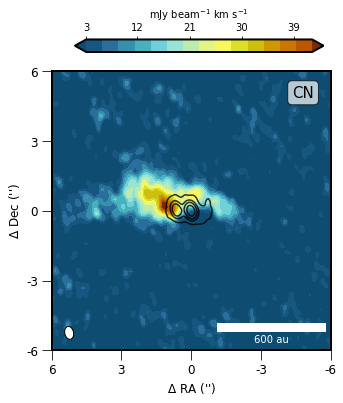

In [107]:
jimothy(manual_freq = frequencies,\
        manual_molname = molecules,\
        manualprefix = prefs,
        manualsource = ['TMC1'],\
        manual_cmap = [cmap_blueorange],\
        eups  = temps,
        chanmap= False,\
        figname = 'cn_-4_-2',\
        number_of_plots=1,\
        hsize=6,\
        wsize=5,\
        rmsmanual=[1,1,1],\
        show_cont=True,\
        coord_manual=False,\
        channels_array = True,\
        factormommax = [1],\
        dvel_tabl = [[-4]],\
        dvel_tabr = [[-2]],\
        zoom_array = [6],\
        array = '12m',\
        ncols = 1,\
        nrows = 1\
       )